In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import linregress, spearmanr, pearsonr


In [2]:
df = pd.read_csv("/Users/fyzeen/FyzeenLocal/GitHub/DivineWellness/data/fulldata.csv")
numeric_cols = ['age','CRS_SCORE', 'MRS_TOTAL_SCORE', 'MRS_ReligiousPractice_Subscale', 'MRS_IntrinsicReligiosity_Subscale', 'HPLP_Health_Promoting_Lifestyle', 'HPLP_Health_Responsibility', 'HPLP_Physical_Activity', 'HPLP_Nutrition', 'HPLP_Spiritual_Growth', 'HPLP_Interpersonal_Relations', 'HPLP_Stress_Management', 'BRS_SCORE', 'PHQ_SCORE', 'GAD_SCORE']
categorical_cols = ['sex', 'income', 'ethnicity']

sex_map = {
    0: 'Male',
    1: 'Female'
}

income_map = {
    0: '$0 - $40,000',
    1: '$40,001 - $75,000',
    2: '$75,001 - $100,000',
    3: '$100,001 - $150,000',
    4: '$150,001 - $250,000',
    5: '$250,001 - $500,000',
    6: '$500,000+',
    99: 'Prefer not to answer'
}

ethnicity_map = {
    1: 'White',
    2: 'Black or African American',
    3: 'American Indian or Alaska Native',
    4: 'Asian',
    5: 'Native Hawaiian or Other Pacific Islander',
    99: 'Prefer not to answer'
}

# Apply mappings
df['sex'] = df['sex'].map(sex_map)
df['income'] = df['income'].map(income_map)
df['ethnicity'] = df['ethnicity'].map(ethnicity_map)

/Users/fyzeen/opt/miniconda3/envs/neurotranslate/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


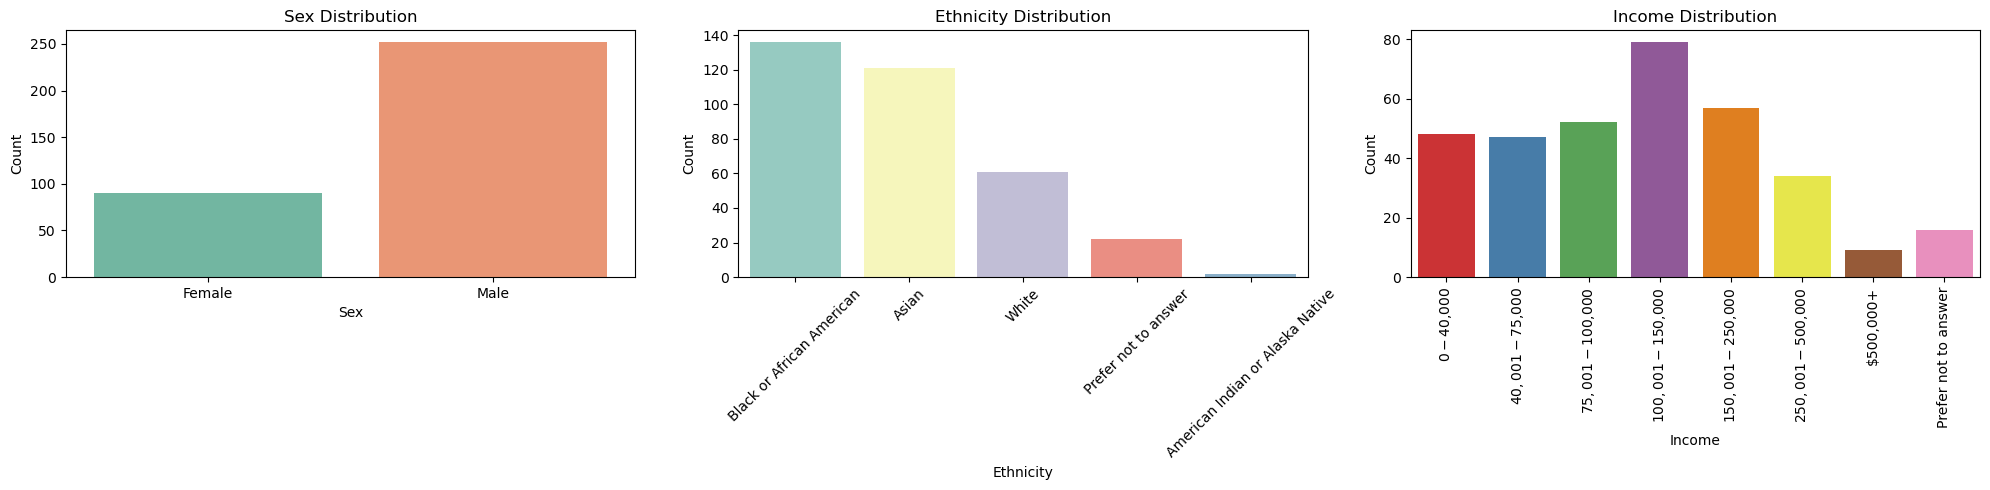

In [3]:
# CHECK DISTRIBUTIONS of categorical data
# Define the desired order for income
income_order = [
    '$0 - $40,000',
    '$40,001 - $75,000',
    '$75,001 - $100,000',
    '$100,001 - $150,000',
    '$150,001 - $250,000',
    '$250,001 - $500,000',
    '$500,000+',
    'Prefer not to answer'
]

dfc = df.copy()
dfc['income'] = pd.Categorical(dfc['income'], categories=income_order, ordered=True)


# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot distribution of sex
sns.countplot(ax=axes[0], data=dfc, x='sex', palette='Set2')
axes[0].set_title('Sex Distribution')
axes[0].set_xlabel('Sex')
axes[0].set_ylabel('Count')

# Plot distribution of ethnicity
sns.countplot(ax=axes[1], data=dfc, x='ethnicity', palette='Set3')
axes[1].set_title('Ethnicity Distribution')
axes[1].set_xlabel('Ethnicity')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

# Plot distribution of income with proper order
sns.countplot(ax=axes[2], data=dfc, x='income', palette='Set1', order=income_order)
axes[2].set_title('Income Distribution')
axes[2].set_xlabel('Income')
axes[2].set_ylabel('Count')
axes[2].tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()
plt.show()

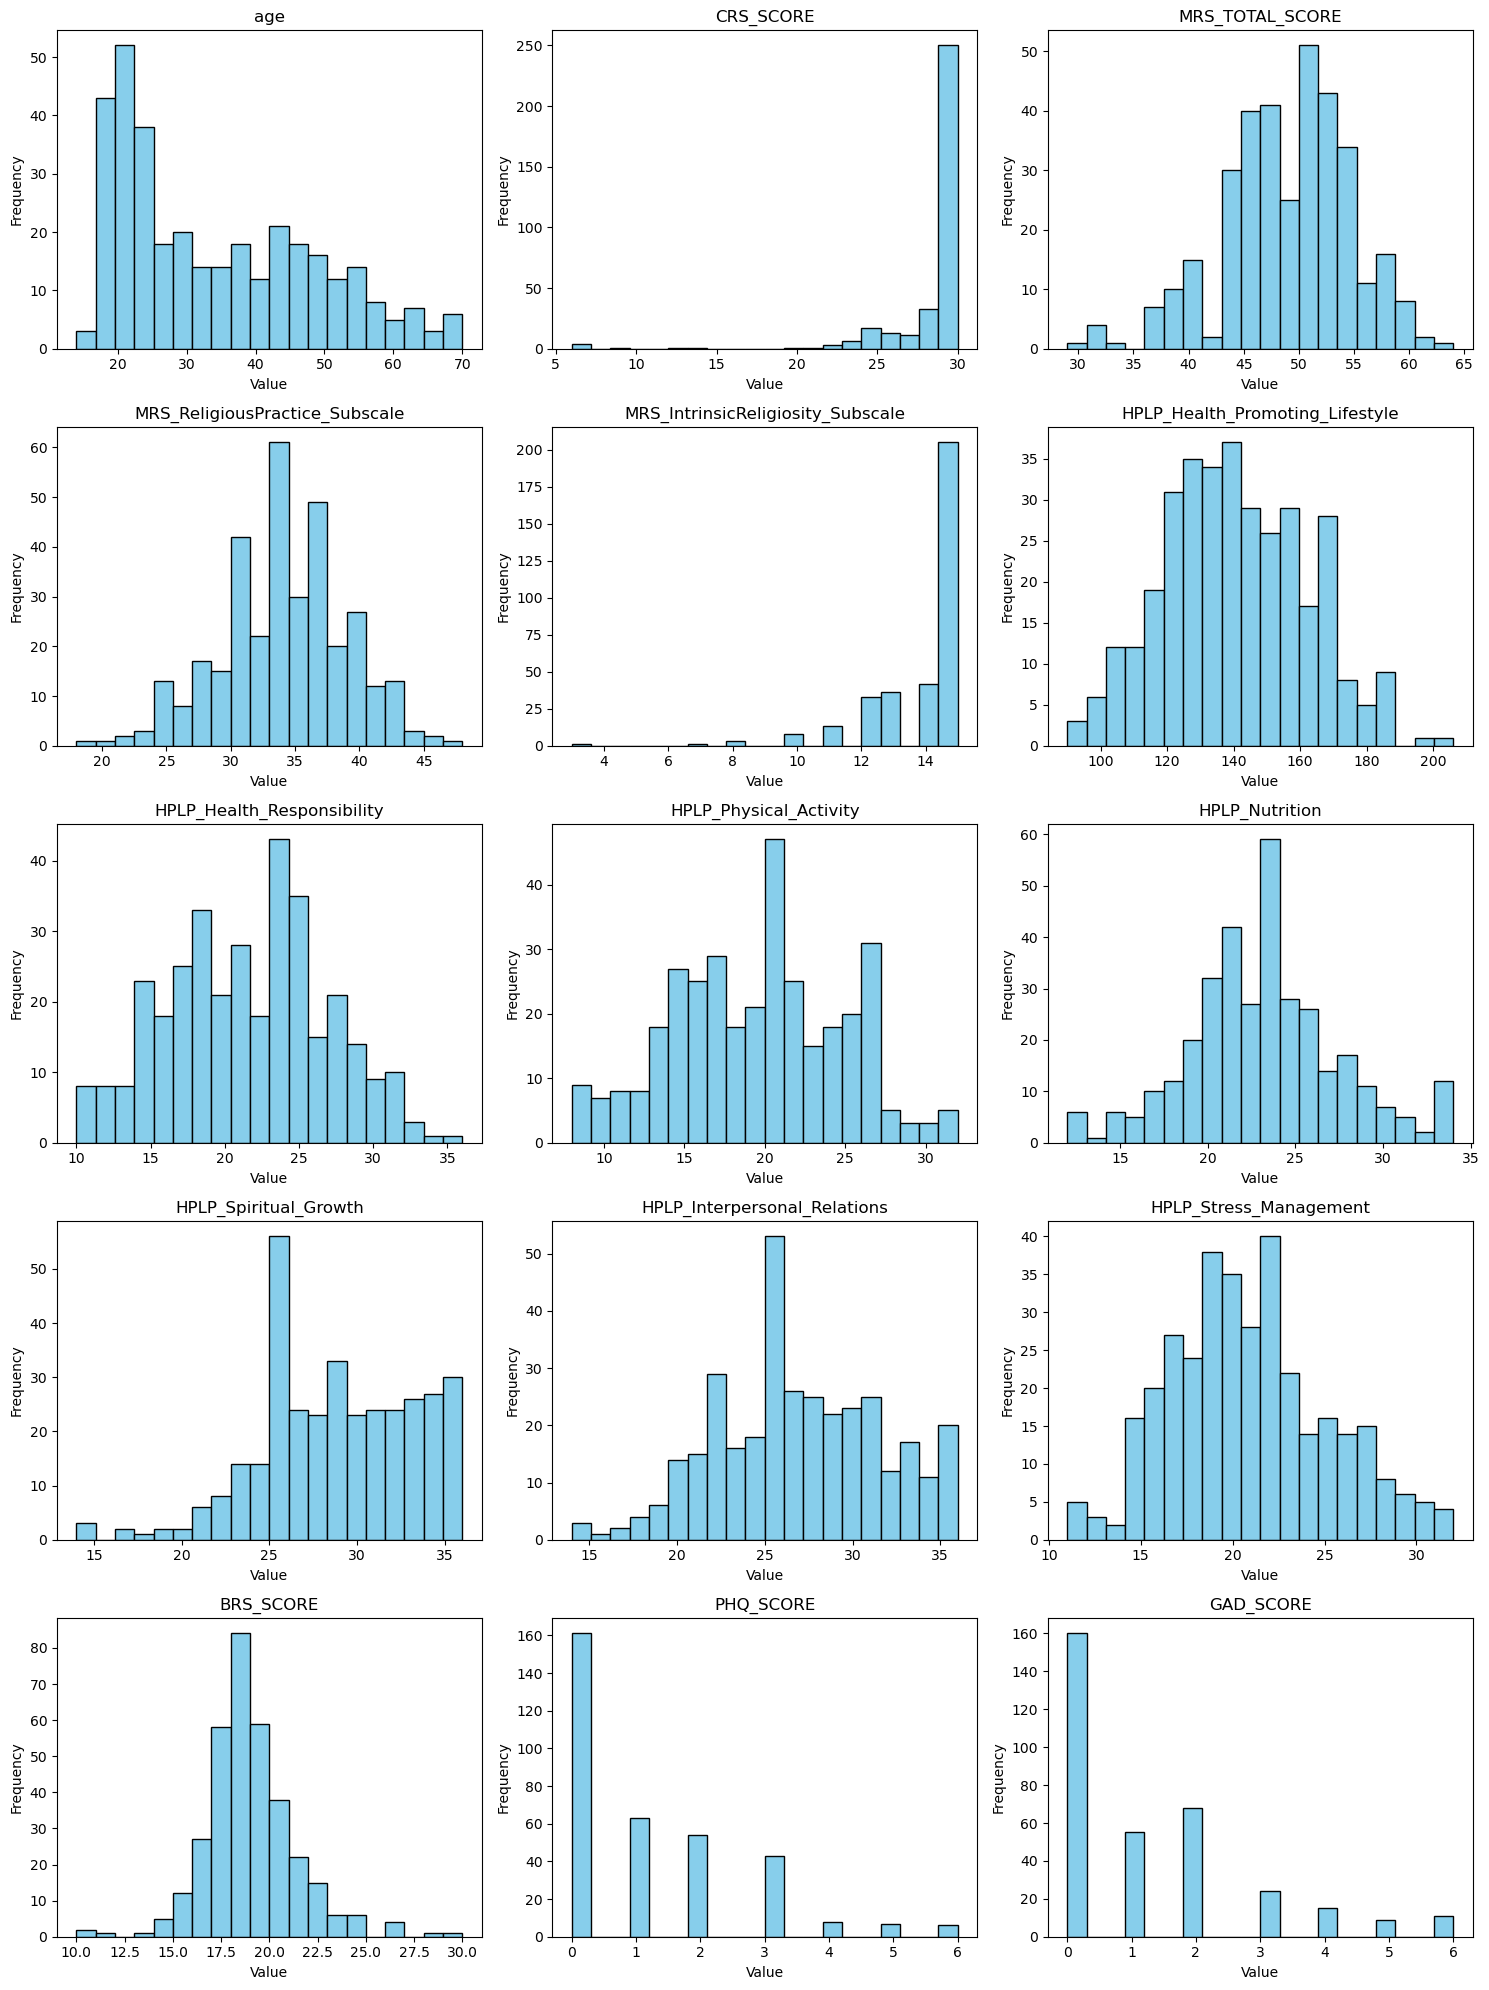

In [4]:
# CHECK DISTRIBUTIONS of numerical data

# Select the subset from df
df_numeric = df[numeric_cols]

# Filter to numeric columns only
n = len(numeric_cols)

# Grid layout
n_cols_per_row = 3
n_rows = math.ceil(n / n_cols_per_row)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols_per_row, figsize=(5 * n_cols_per_row, 4 * n_rows))
axes = axes.flatten()

# Plot histograms
for i, col in enumerate(numeric_cols):
    axes[i].hist(df_numeric[col].dropna(), bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Turn off unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

df_numeric = df_numeric.drop('age', axis=1)

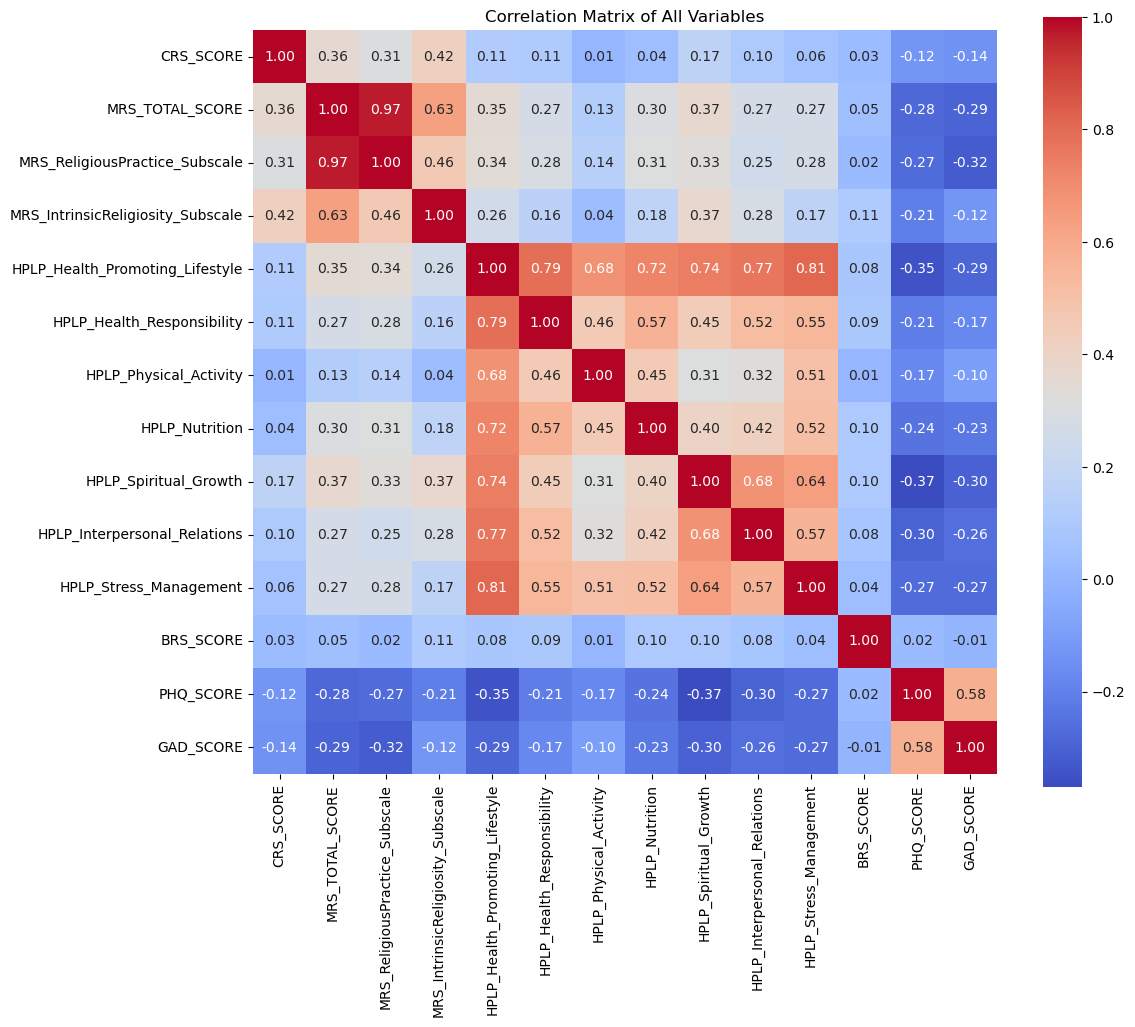

In [5]:
# Correlation Matrix to find general relationships - NO CONTROLS
plt.figure(figsize=(12, 10))
corr = df_numeric.corr(method="spearman")
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix of All Variables")
plt.show()

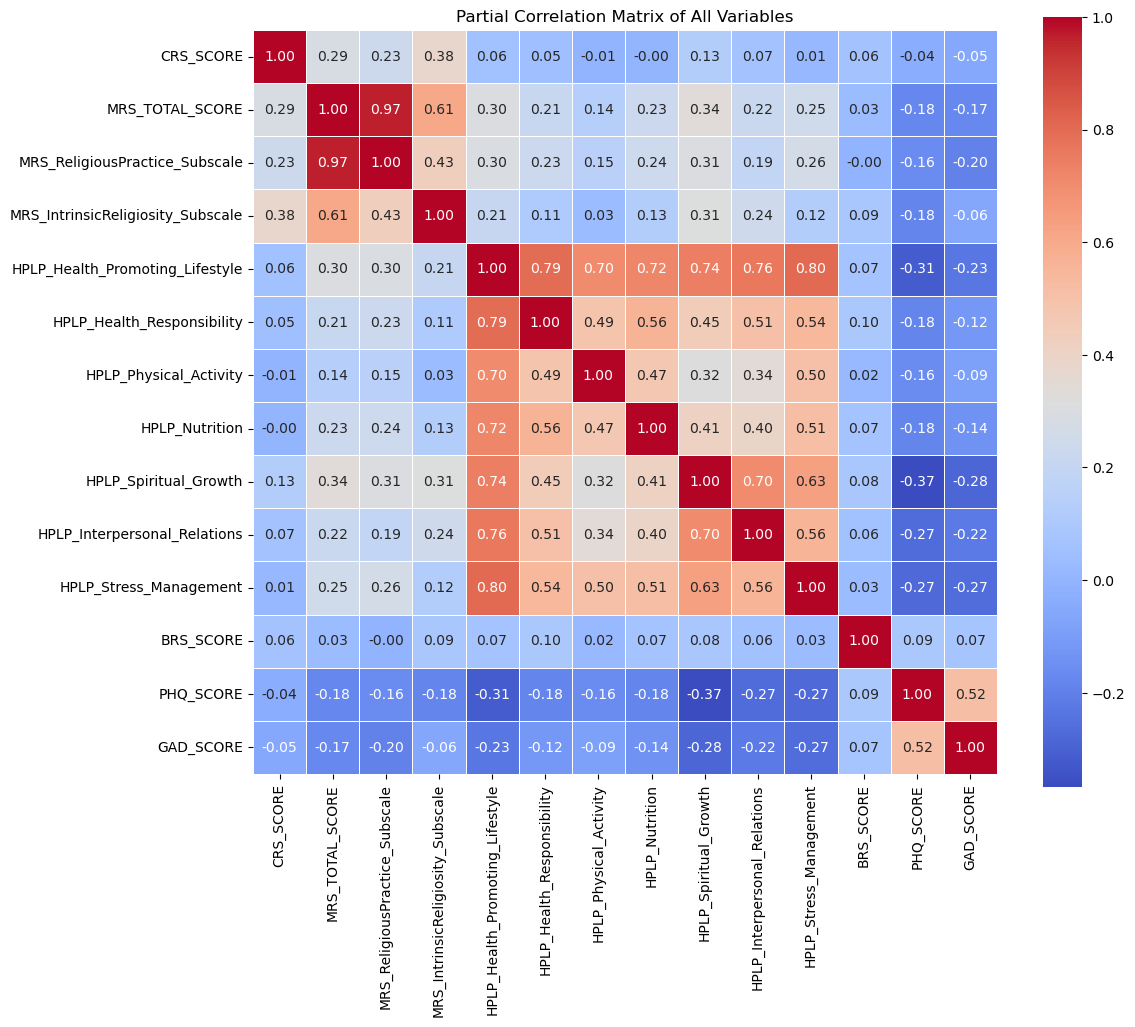

In [6]:
# PARTIAL CORRELATION MATRIX
def partial_corr_matrix(data, variables, covars):
    corr_matrix = pd.DataFrame(index=variables, columns=variables)

    for var1 in variables:
        for var2 in variables:
            # Define the formula for regression with categorical covariates
            formula_x = f"{var1} ~ {' + '.join(covars)}"
            formula_y = f"{var2} ~ {' + '.join(covars)}"
            
            # Fit the models
            model_x = smf.ols(formula=formula_x, data=data).fit()
            model_y = smf.ols(formula=formula_y, data=data).fit()

            # Get residuals
            residual_x = model_x.resid
            residual_y = model_y.resid

            # Compute the correlation between the residuals
            corr_matrix.loc[var1, var2] = spearmanr(residual_x, residual_y).statistic #np.corrcoef(residual_x, residual_y)[0, 1]

    return corr_matrix

variables = df_numeric.columns
covars = ['age', 'C(sex)', 'C(ethnicity)', 'C(income)']

corr_matrix = partial_corr_matrix(df, variables, covars)

plt.figure(figsize=(12, 10)) 
sns.heatmap(corr_matrix.astype(float), annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Partial Correlation Matrix of All Variables")
plt.show()

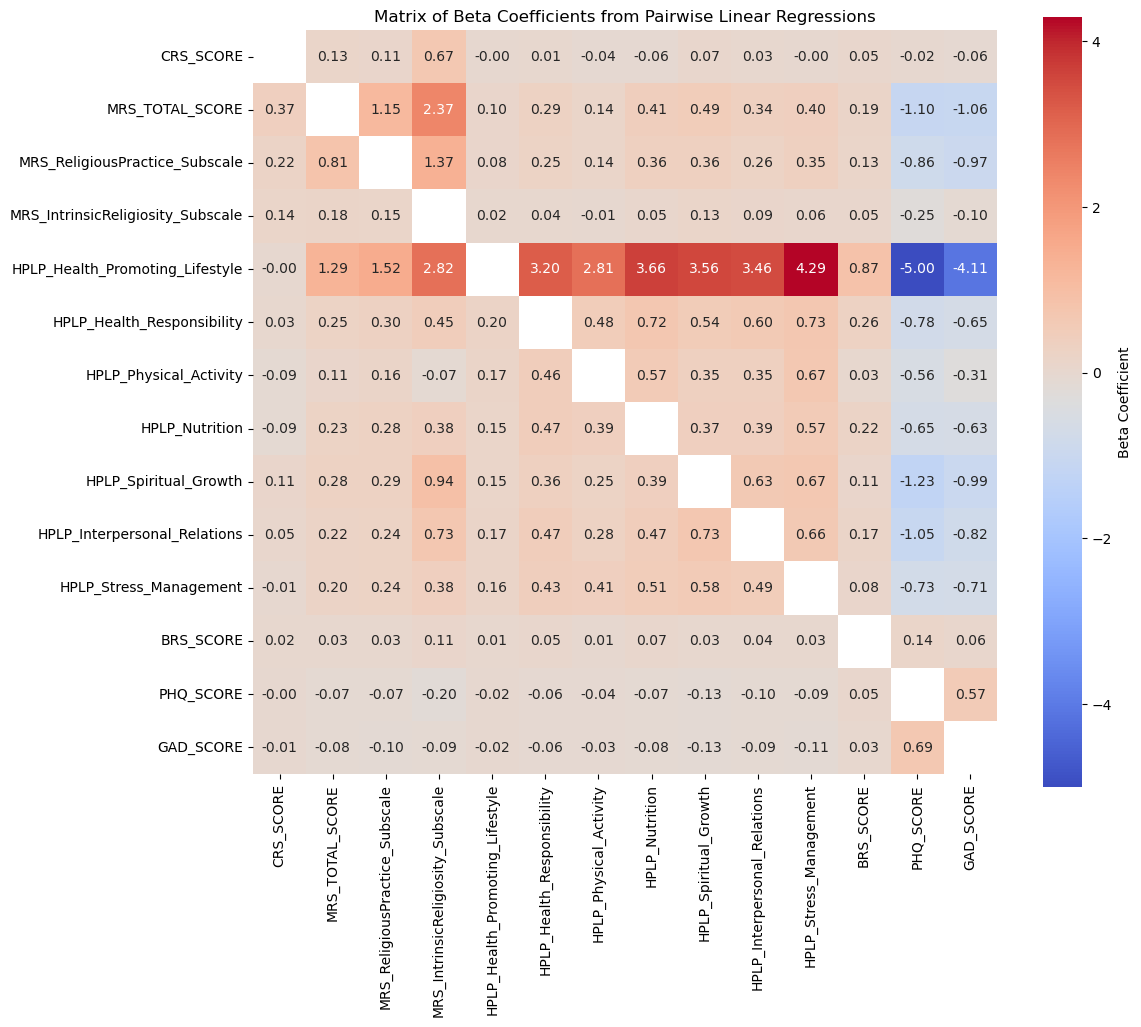

In [7]:
# REGRESSIONS WITH NO CONTROLS
variables = df_numeric.columns
betas = pd.DataFrame(index=variables, columns=variables, dtype=float)

for y_var in variables:
    for x_var in variables:
        if x_var == y_var:
            betas.loc[y_var, x_var] = np.nan  # No regression of variable on itself
        else:
            # X = df_numeric[[x_var]]
            # X = sm.add_constant(X)  # Add intercept
            # y = df_numeric[y_var]
            
            # model = sm.OLS(y, X).fit()
            # betas.loc[y_var, x_var] = model.params[x_var]  # beta coefficient for x_var
            formula = f"{y_var} ~ {x_var}"
            model = smf.ols(formula=formula, data=df).fit()
            betas.loc[y_var, x_var] = model.params.get(x_var, np.nan)

plt.figure(figsize=(12, 10))
sns.heatmap(betas, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'label': 'Beta Coefficient'})
plt.title("Matrix of Beta Coefficients from Pairwise Linear Regressions")
plt.show()

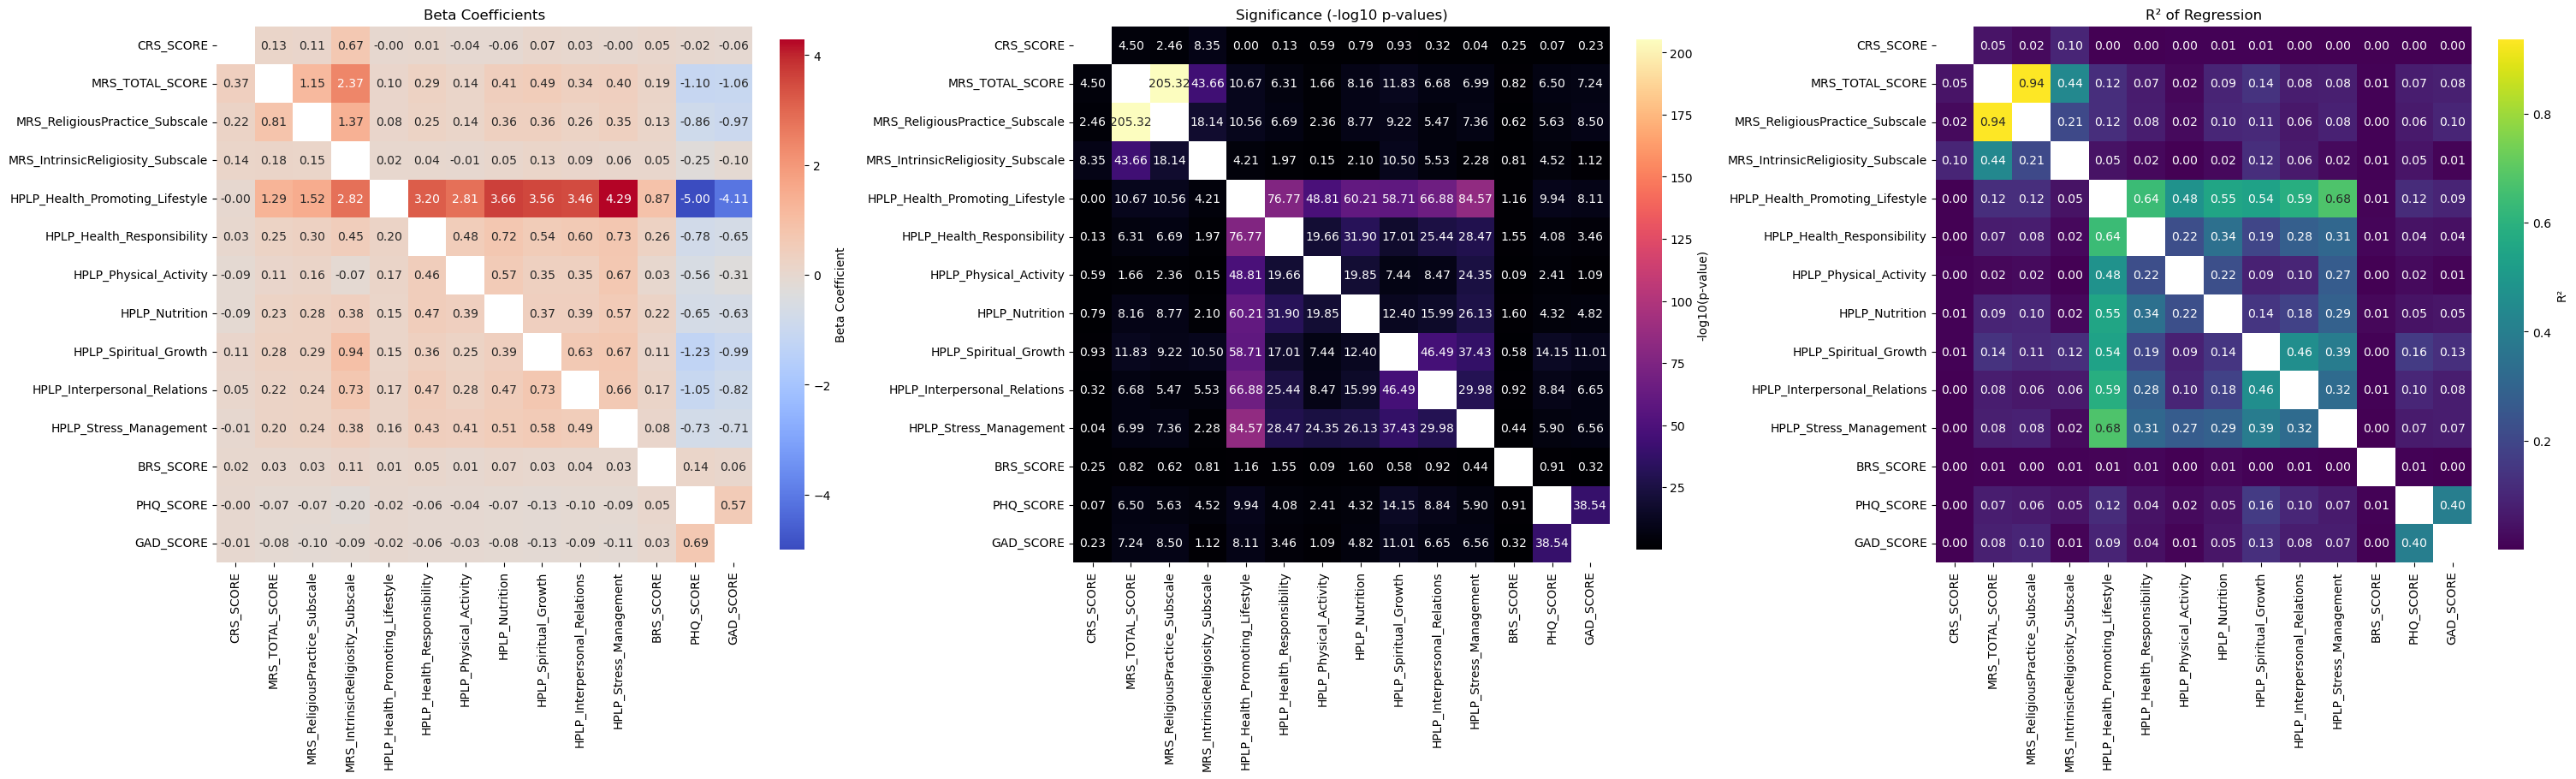

In [8]:
variables = df_numeric.columns

betas = pd.DataFrame(index=variables, columns=variables, dtype=float)
pvals = pd.DataFrame(index=variables, columns=variables, dtype=float)
r2s = pd.DataFrame(index=variables, columns=variables, dtype=float)

for y_var in variables:
    for x_var in variables:
        if x_var == y_var:
            betas.loc[y_var, x_var] = np.nan
            pvals.loc[y_var, x_var] = np.nan
            r2s.loc[y_var, x_var] = np.nan
        else:
            formula = f"{y_var} ~ {x_var}"
            model = smf.ols(formula=formula, data=df).fit()
            betas.loc[y_var, x_var] = model.params.get(x_var, np.nan)
            pvals.loc[y_var, x_var] = model.pvalues.get(x_var, np.nan)
            r2s.loc[y_var, x_var] = model.rsquared

# Transform p-values for visualization (-log10 scale)
neg_log_pvals = -np.log10(pvals.astype(float))

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(30, 12), constrained_layout=True)

sns.heatmap(betas, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            cbar_kws={'label': 'Beta Coefficient', 'shrink': 0.5}, ax=axes[0])
axes[0].set_title('Beta Coefficients')

sns.heatmap(neg_log_pvals, annot=True, fmt=".2f", cmap='magma', square=True,
            cbar_kws={'label': '-log10(p-value)', 'shrink': 0.5}, ax=axes[1])
axes[1].set_title('Significance (-log10 p-values)')

sns.heatmap(r2s, annot=True, fmt=".2f", cmap='viridis', square=True,
            cbar_kws={'label': 'R²', 'shrink': 0.5}, ax=axes[2])
axes[2].set_title('R² of Regression')
plt.show()

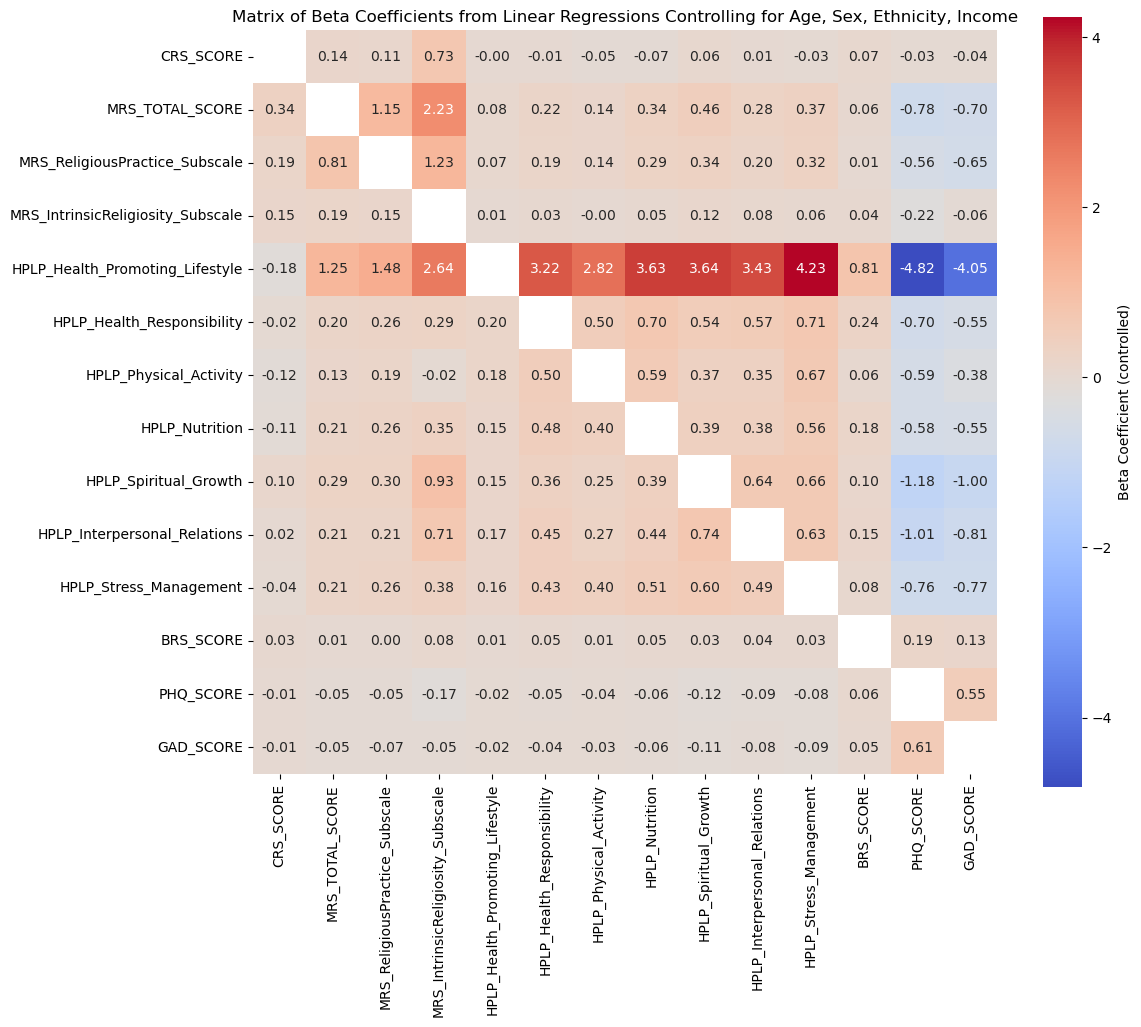

In [9]:
# REGRESSION WITH ALL CONTROLS

variables = df_numeric.columns  # Numeric vars only for y and x

betas_controlled = pd.DataFrame(index=variables, columns=variables, dtype=float)

for y_var in variables:
    for x_var in variables:
        if x_var == y_var:
            betas_controlled.loc[y_var, x_var] = np.nan
        else:
            formula = f"{y_var} ~ {x_var} + age + C(sex) + C(ethnicity) + C(income)"
            model = smf.ols(formula=formula, data=df).fit()
            betas_controlled.loc[y_var, x_var] = model.params.get(x_var, np.nan)

plt.figure(figsize=(12, 10))
sns.heatmap(betas_controlled, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            cbar_kws={'label': 'Beta Coefficient (controlled)'})
plt.title("Matrix of Beta Coefficients from Linear Regressions Controlling for Age, Sex, Ethnicity, Income")
plt.show()

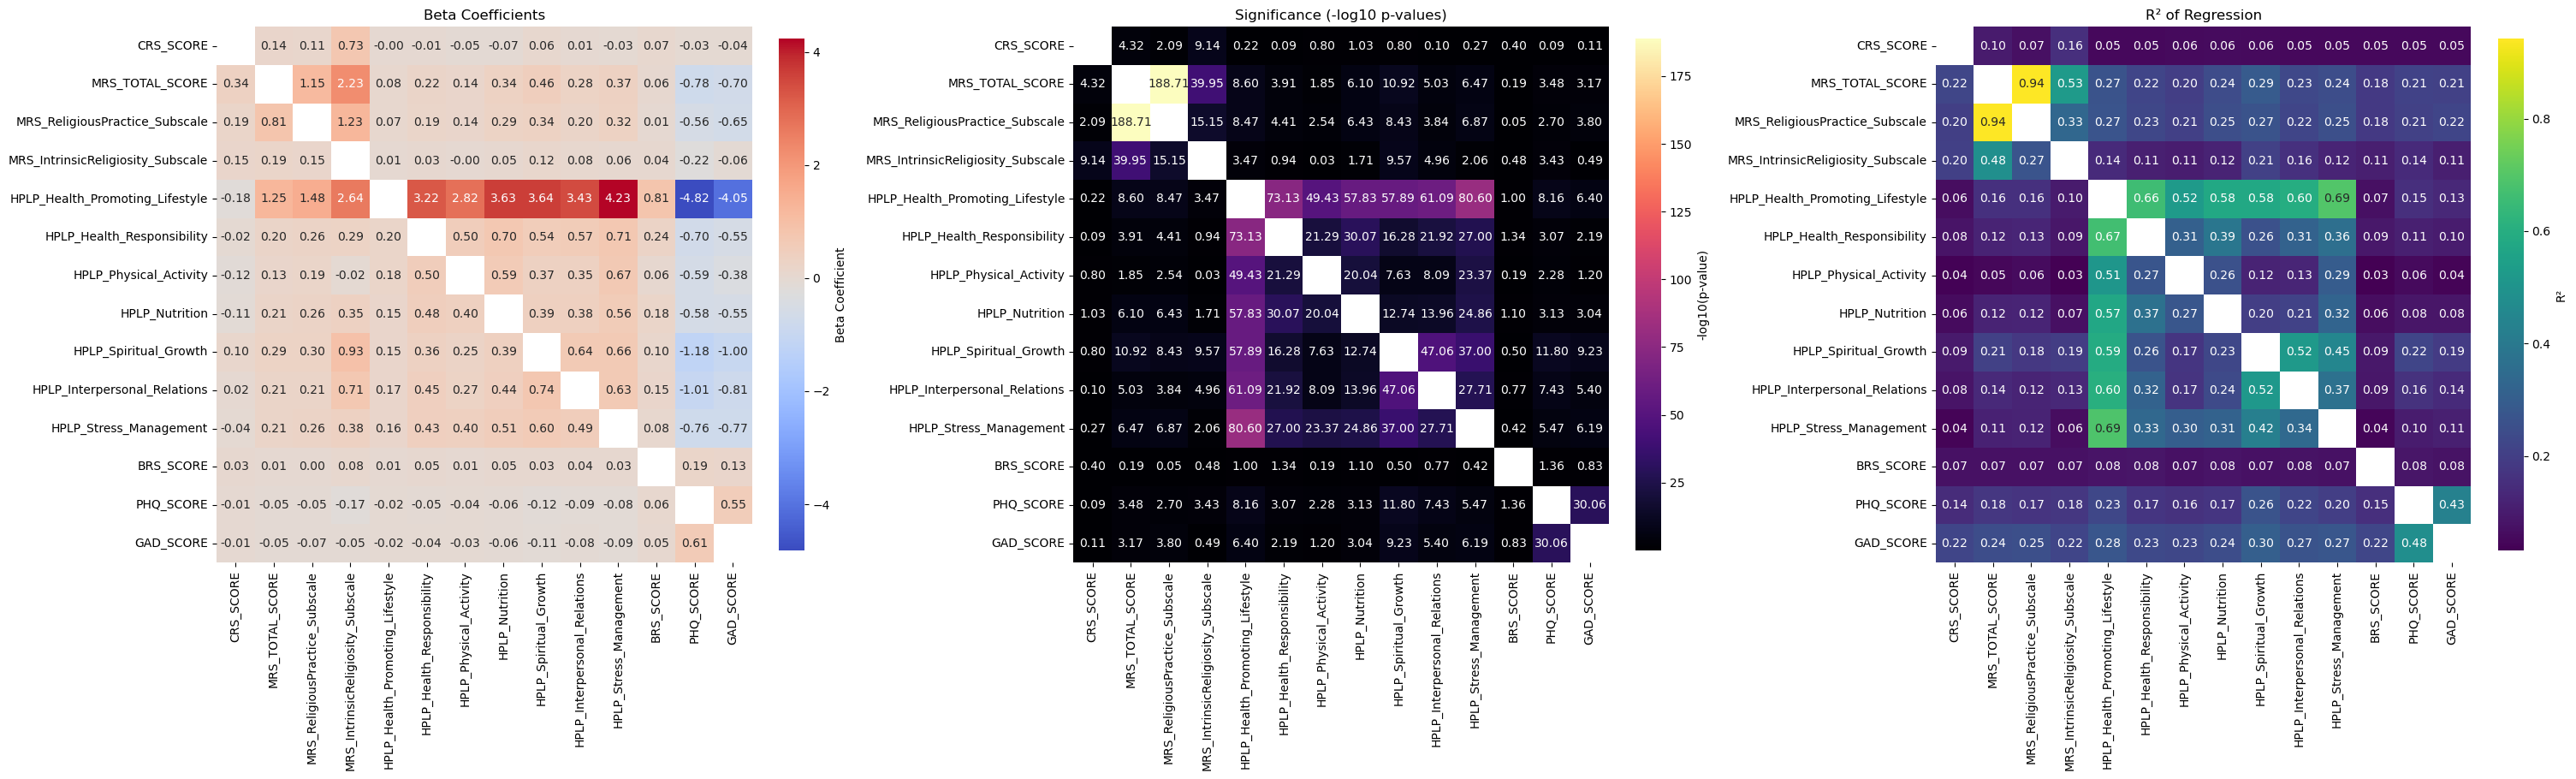

In [10]:
variables = df_numeric.columns

betas = pd.DataFrame(index=variables, columns=variables, dtype=float)
pvals = pd.DataFrame(index=variables, columns=variables, dtype=float)
r2s = pd.DataFrame(index=variables, columns=variables, dtype=float)

for y_var in variables:
    for x_var in variables:
        if x_var == y_var:
            betas.loc[y_var, x_var] = np.nan
            pvals.loc[y_var, x_var] = np.nan
            r2s.loc[y_var, x_var] = np.nan
        else:
            formula = f"{y_var} ~ {x_var} + age + C(sex) + C(ethnicity) + C(income)"
            model = smf.ols(formula=formula, data=df).fit()
            betas.loc[y_var, x_var] = model.params.get(x_var, np.nan)
            pvals.loc[y_var, x_var] = model.pvalues.get(x_var, np.nan)
            r2s.loc[y_var, x_var] = model.rsquared

# Transform p-values for visualization (-log10 scale)
neg_log_pvals = -np.log10(pvals.astype(float))

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(30, 20), constrained_layout=True)

sns.heatmap(betas, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            cbar_kws={'label': 'Beta Coefficient', 'shrink': 0.3}, ax=axes[0])
axes[0].set_title('Beta Coefficients')

sns.heatmap(neg_log_pvals, annot=True, fmt=".2f", cmap='magma', square=True,
            cbar_kws={'label': '-log10(p-value)', 'shrink': 0.3}, ax=axes[1])
axes[1].set_title('Significance (-log10 p-values)')

sns.heatmap(r2s, annot=True, fmt=".2f", cmap='viridis', square=True,
            cbar_kws={'label': 'R²', 'shrink': 0.3}, ax=axes[2])
axes[2].set_title('R² of Regression')
plt.show()

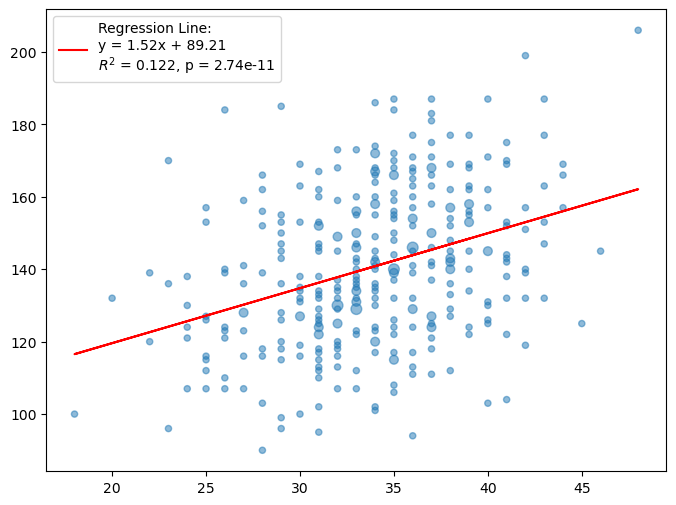

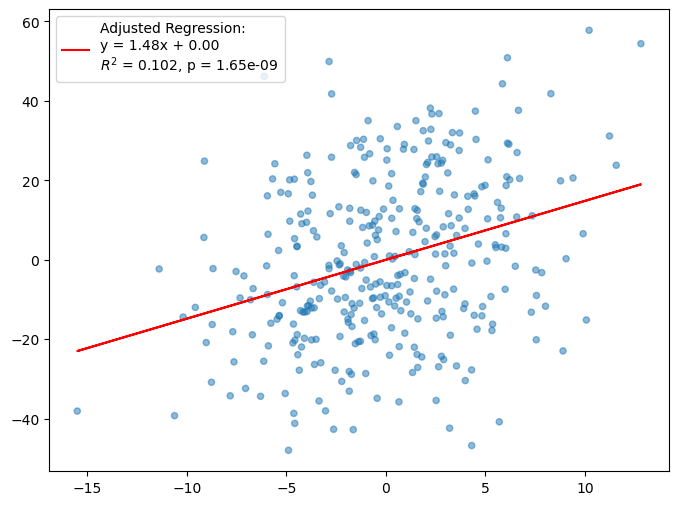

In [11]:
# Creating scatter
# options: ['CRS_SCORE', 'MRS_TOTAL_SCORE', 'MRS_ReligiousPractice_Subscale', 'MRS_IntrinsicReligiosity_Subscale', 'HPLP_Health_Promoting_Lifestyle', 'HPLP_Health_Responsibility', 'HPLP_Physical_Activity', 'HPLP_Nutrition', 'HPLP_Spiritual_Growth', 'HPLP_Interpersonal_Relations', 'HPLP_Stress_Management', 'BRS_SCORE', 'PHQ_SCORE', 'GAD_SCORE']
x = 'MRS_ReligiousPractice_Subscale'
y = 'HPLP_Health_Promoting_Lifestyle'

slope, intercept, r_value, p_value, std_err = linregress(df[x], df[y])
line = slope * df[x] + intercept
r_squared = r_value ** 2

# Plot
plt.figure(figsize=(8, 6))

counts = df.groupby([x, y]).size().reset_index(name='count')
plt.scatter(counts[x], counts[y], s=counts['count']*20, alpha=0.5)

# Plot the best fit line
plt.plot(df[x], line, color='red',
         label=f'Regression Line:\ny = {slope:.2f}x + {intercept:.2f}\n'
               f'$R^2$ = {r_squared:.3f}, p = {p_value:.3g}')

plt.legend()
plt.grid(False)
plt.show()


# Regress x and y separately on covariates to get residuals
covariates = 'age + C(sex) + C(ethnicity) + C(income)'

# Residuals for x
model_x = smf.ols(f"{x} ~ {covariates}", data=df).fit()
df['x_resid'] = model_x.resid

# Residuals for y
model_y = smf.ols(f"{y} ~ {covariates}", data=df).fit()
df['y_resid'] = model_y.resid

# Linear regression on residuals
slope, intercept, r_value, p_value, std_err = linregress(df['x_resid'], df['y_resid'])
line = slope * df['x_resid'] + intercept
r_squared = r_value ** 2

# Plotting
plt.figure(figsize=(8, 6))

# Create size-weighted scatter
counts = df.groupby(['x_resid', 'y_resid']).size().reset_index(name='count')
plt.scatter(counts['x_resid'], counts['y_resid'], s=counts['count']*20, alpha=0.5)

# Plot regression line
plt.plot(df['x_resid'], line, color='red',
         label=f'Adjusted Regression:\ny = {slope:.2f}x + {intercept:.2f}\n'
               f'$R^2$ = {r_squared:.3f}, p = {p_value:.3g}')

plt.legend()
plt.grid(False)
plt.show()

In [12]:
# Multivariate/Interaction regressions

# options: ['CRS_SCORE', 'MRS_TOTAL_SCORE', 'MRS_ReligiousPractice_Subscale', 'MRS_IntrinsicReligiosity_Subscale', 'HPLP_Health_Promoting_Lifestyle', 'HPLP_Health_Responsibility', 'HPLP_Physical_Activity', 'HPLP_Nutrition', 'HPLP_Spiritual_Growth', 'HPLP_Interpersonal_Relations', 'HPLP_Stress_Management', 'BRS_SCORE', 'PHQ_SCORE', 'GAD_SCORE']

y = 'PHQ_SCORE'
x = 'MRS_TOTAL_SCORE * C(sex)'

# Formula options below
#formula = f"{y} ~ {x} + age + C(sex) + C(ethnicity) + C(income)" # for controlling for sex
formula = f"{y} ~ {x}"

# Fit OLS model using formula notation
model = smf.ols(formula=formula, data=df).fit()

# Display regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              PHQ_SCORE   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     14.64
Date:                Wed, 28 May 2025   Prob (F-statistic):           5.47e-09
Time:                        19:32:03   Log-Likelihood:                -589.32
No. Observations:                 342   AIC:                             1187.
Df Residuals:                     338   BIC:                             1202.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [16]:
def significance_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

def all_correlation_table_with_significance(df, variables, covars):
    results = []

    for var1, var2 in combinations(variables, 2):
        # --- Full correlations ---
        pearson_full_val, pearson_full_p = pearsonr(df[var1], df[var2])
        spearman_full_stat = spearmanr(df[var1], df[var2])
        spearman_full_val, spearman_full_p = spearman_full_stat.statistic, spearman_full_stat.pvalue

        # --- Partial correlations using residuals ---
        model1 = smf.ols(f"{var1} ~ {' + '.join(covars)}", data=df).fit()
        model2 = smf.ols(f"{var2} ~ {' + '.join(covars)}", data=df).fit()

        resid1 = model1.resid
        resid2 = model2.resid

        pearson_partial_val, pearson_partial_p = pearsonr(resid1, resid2)
        spearman_partial_stat = spearmanr(resid1, resid2)
        spearman_partial_val, spearman_partial_p = spearman_partial_stat.statistic, spearman_partial_stat.pvalue

        # Add stars
        results.append({
            "Variate 1": var1,
            "Variate 2": var2,
            "Pearson Full": f"{pearson_full_val:.3f}{significance_stars(pearson_full_p)}",
            "Pearson Partial": f"{pearson_partial_val:.3f}{significance_stars(pearson_partial_p)}",
            "Spearman Full": f"{spearman_full_val:.3f}{significance_stars(spearman_full_p)}",
            "Spearman Partial": f"{spearman_partial_val:.3f}{significance_stars(spearman_partial_p)}"
        })

    return pd.DataFrame(results)


variables = df_numeric.columns
covars = ['age', 'C(sex)', 'C(ethnicity)', 'C(income)']
out = all_correlation_table_with_significance(df, variables, covars)
out.to_clipboard()